In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [17]:
# Load and preprocess data
url = 'data/eng_-french.csv'
data = pd.read_csv(url)
data.rename(columns={"English words/sentences": "Eng", "French words/sentences": "Frn"}, inplace=True)

def tokenize_and_pad(texts, max_len=None):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)
    return padded_sequences, tokenizer

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'])
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'])

eng_max_len = max(len(seq) for seq in eng_sequences)
frn_max_len = max(len(seq) for seq in frn_sequences)

eng_sequences, eng_tokenizer = tokenize_and_pad(data['Eng'], max_len=eng_max_len)
frn_sequences, frn_tokenizer = tokenize_and_pad(data['Frn'], max_len=frn_max_len)

eng_vocab_size = len(eng_tokenizer.word_index) + 1
frn_vocab_size = len(frn_tokenizer.word_index) + 1

train_eng, test_eng, train_frn, test_frn = train_test_split(eng_sequences, frn_sequences, test_size=0.2, random_state=42)




In [21]:
# Define Seq2Seq model with LSTM
def define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim=256, lstm_units=256):
    # Encoder
    encoder_inputs = Input(shape=(eng_max_len,))
    encoder_embedding = Embedding(eng_vocab_size, embedding_dim, input_length=eng_max_len, mask_zero=True)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(frn_max_len,))
    decoder_embedding = Embedding(frn_vocab_size, embedding_dim, input_length=frn_max_len, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(frn_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # Create separate models for the encoder and decoder
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(lstm_units,))
    decoder_state_input_c = Input(shape=(lstm_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model


In [22]:
embedding_dim = 128
lstm_units = 128
batch_size = 64
epochs = 5
learning_rate = 1e-3

model, encoder_model, decoder_model = define_seq2seq_model(eng_vocab_size, frn_vocab_size, eng_max_len, frn_max_len, embedding_dim, lstm_units)
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy')

# Prepare data for the decoder
train_frn_input = train_frn[:, :-1]  # input 
train_frn_output = train_frn[:, 1:]  # expected output 

# Padding train_frn_input to ensure it matches the required input shape
train_frn_input = pad_sequences(train_frn_input, maxlen=frn_max_len, padding='post')
train_frn_output = pad_sequences(train_frn_output, maxlen=frn_max_len, padding='post')

Epoch 1/2
1757/1757 [==============================] - 3043s 2s/step - loss: 5.0863 - val_loss: 4.1954
Epoch 2/2
1757/1757 [==============================] - 3623s 2s/step - loss: 3.5890 - val_loss: 3.3261


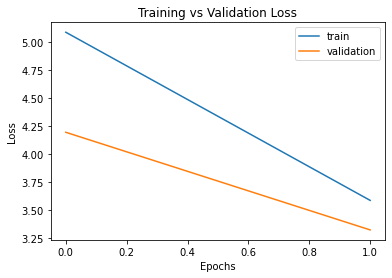

In [23]:
# Train the model
history = model.fit([train_eng, train_frn_input], train_frn_output,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

# Plotting the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()

In [27]:
# Function to translate using the trained model
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = 1  # start character (index 1)

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = frn_tokenizer.index_word.get(sampled_token_index, '')

        decoded_sentence += ' ' + sampled_word

        if (sampled_word == '' or len(decoded_sentence.split()) >= frn_max_len):
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence.strip()

In [30]:
# Translate some test sentences
for i in range(10):
    input_seq = test_eng[i:i+1]
    translated_sentence = decode_sequence(input_seq)
    print('Input:', data['Eng'].iloc[i])
    print('Translation:', translated_sentence)
    print()


1/1 [==============================] - 0s 133ms/step
Input: Hi.
Translation: suis un bon

1/1 [==============================] - 0s 86ms/step
Input: Run!
Translation: pense que tom est ici

1/1 [==============================] - 0s 119ms/step
Input: Run!
Translation: suis en train de faire des cheveux

1/1 [==============================] - 0s 68ms/step
Input: Who?
Translation: ne suis pas à l'école à la maison de la maison

1/1 [==============================] - 0s 152ms/step
Input: Wow!
Translation: sais que tu as fait de faire de ce qu'il est en train de faire

1/1 [==============================] - 0s 79ms/step
Input: Fire!
Translation: suis allé à lui

1/1 [==============================] - 0s 90ms/step
Input: Help!
Translation: me suis senti que les deux

1/1 [==============================] - 0s 103ms/step
Input: Jump.
Translation: ne suis pas assez de mal

1/1 [==============================] - 0s 210ms/step
Input: Stop!
Translation: suis tombé

1/1 [===========================